In [0]:
movies_path = "/FileStore/tables/movies.csv"
ratings_path = "/FileStore/tables/ratings.csv"
tags_path = "/FileStore/tables/tags.csv"

movies_df = spark.read.csv(movies_path, header=True, inferSchema=True)
ratings_df = spark.read.csv(ratings_path, header=True, inferSchema=True)
tags_df = spark.read.csv(tags_path, header=True, inferSchema=True)

movies_df.printSchema()
ratings_df.printSchema()
tags_df.printSchema()


root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: integer (nullable = true)



In [0]:
# Show sample rows
movies_df.show(5)
ratings_df.show(5)
tags_df.show(5)

# Count records
print("Movies:", movies_df.count())
print("Ratings:", ratings_df.count())
print("Tags:", tags_df.count())


+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|


In [0]:
# Check for nulls
from pyspark.sql.functions import col, isnan, when, count

def null_check(df):
    df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

null_check(movies_df)
null_check(ratings_df)
null_check(tags_df)


+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+

+------+-------+---+---------+
|userId|movieId|tag|timestamp|
+------+-------+---+---------+
|     0|      0|  0|        0|
+------+-------+---+---------+



In [0]:
from pyspark.sql.functions import regexp_extract, split, col, trim

# Extract year using regex (4-digit number inside parentheses)
movies_df = movies_df.withColumn("year", regexp_extract(col("title"), r"\((\d{4})\)", 1))

# Remove year from title to keep clean movie title
movies_df = movies_df.withColumn("clean_title", regexp_extract(col("title"), r"^(.+?)\s\(\d{4}\)$", 1))

# Split genres into array (genres separated by |)
movies_df = movies_df.withColumn("genres_array", split(col("genres"), "\|"))

# Show cleaned data sample
movies_df.select("title", "clean_title", "year", "genres", "genres_array").show(5, truncate=False)


+----------------------------------+---------------------------+----+-------------------------------------------+-------------------------------------------------+
|title                             |clean_title                |year|genres                                     |genres_array                                     |
+----------------------------------+---------------------------+----+-------------------------------------------+-------------------------------------------------+
|Toy Story (1995)                  |Toy Story                  |1995|Adventure|Animation|Children|Comedy|Fantasy|[Adventure, Animation, Children, Comedy, Fantasy]|
|Jumanji (1995)                    |Jumanji                    |1995|Adventure|Children|Fantasy                 |[Adventure, Children, Fantasy]                   |
|Grumpier Old Men (1995)           |Grumpier Old Men           |1995|Comedy|Romance                             |[Comedy, Romance]                                |
|Waiting to Exha

In [0]:
from pyspark.sql.functions import from_unixtime

# Convert timestamp to date
ratings_df = ratings_df.withColumn("rating_date", from_unixtime(col("timestamp")).cast("date"))

# Show sample
ratings_df.select("userId", "movieId", "rating", "rating_date").show(5)


+------+-------+------+-----------+
|userId|movieId|rating|rating_date|
+------+-------+------+-----------+
|     1|      1|   4.0| 2000-07-30|
|     1|      3|   4.0| 2000-07-30|
|     1|      6|   4.0| 2000-07-30|
|     1|     47|   5.0| 2000-07-30|
|     1|     50|   5.0| 2000-07-30|
+------+-------+------+-----------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import lower

tags_df = tags_df.filter(col("tag").isNotNull())
tags_df = tags_df.withColumn("tag", lower(col("tag")))

tags_df.show(5)


+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   boxing story|1445715207|
|     2|  89774|            mma|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [0]:
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")
tags_df.createOrReplaceTempView("tags")


In [0]:
%sql
-- Count movies per year
SELECT year, COUNT(*) as movie_count 
FROM movies 
GROUP BY year 
ORDER BY year DESC;



year,movie_count
2018,41
2017,147
2016,218
2015,274
2014,278
2013,239
2012,233
2011,254
2010,247
2009,282


In [0]:
%sql
-- Top genres by movie count
SELECT genre, COUNT(*) as count FROM (
  SELECT explode(genres_array) AS genre FROM movies
)
GROUP BY genre ORDER BY count DESC;

genre,count
Drama,4361
Comedy,3756
Thriller,1894
Action,1828
Romance,1596
Adventure,1263
Crime,1199
Sci-Fi,980
Horror,978
Fantasy,779


In [0]:
%sql
-- Average rating per movie
SELECT m.clean_title, AVG(r.rating) as avg_rating, COUNT(r.rating) as num_ratings
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
GROUP BY m.clean_title ORDER BY avg_rating DESC LIMIT 10;


clean_title,avg_rating,num_ratings
On the Other Side of the Tracks (De l'autre côté du périph),5.0,1
Chinese Puzzle (Casse-tête chinois),5.0,1
My Love,5.0,1
Satin Rouge,5.0,1
My Left Eye Sees Ghosts (Ngo joh aan gin diy gwai),5.0,1
Happy Feet Two,5.0,1
De platte jungle,5.0,1
"Summer's Tale, A (Conte d'été)",5.0,1
"Snowflake, the White Gorilla",5.0,1
"Act of Killing, The",5.0,1


In [0]:
from pyspark.sql.functions import desc

# Count number of ratings per movie
movie_rating_counts = ratings_df.groupBy("movieId").count()

# Join with movies to get titles
popular_movies = movie_rating_counts.join(movies_df, "movieId") \
    .select("clean_title", "count") \
    .orderBy(desc("count"))

display(popular_movies.limit(20))


clean_title,count
Forrest Gump,329
"Shawshank Redemption, The",317
Pulp Fiction,307
"Silence of the Lambs, The",279
"Matrix, The",278
Star Wars: Episode IV - A New Hope,251
Jurassic Park,238
Braveheart,237
Terminator 2: Judgment Day,224
Schindler's List,220


In [0]:
from pyspark.sql.functions import explode, avg

# Explode genres array
genres_exploded = movies_df.select("movieId", explode("genres_array").alias("genre"))

# Join with ratings
genre_ratings = genres_exploded.join(ratings_df, "movieId")

# Calculate average rating per genre
avg_ratings_per_genre = genre_ratings.groupBy("genre").agg(avg("rating").alias("avg_rating"))

display(avg_ratings_per_genre.orderBy(desc("avg_rating")))


genre,avg_rating
Film-Noir,3.920114942528736
War,3.8082938876312
Documentary,3.797785069729286
Crime,3.658293867274144
Drama,3.6561844113718758
Mystery,3.632460255407871
Animation,3.6299370349170004
IMAX,3.618335343787696
Western,3.583937823834197
Musical,3.5636781053649105


In [0]:
movies_per_year = movies_df.groupBy("year").count().orderBy("year")
display(movies_per_year)


year,count
,13
1902,1
1903,1
1908,1
1915,1
1916,4
1917,1
1919,1
1920,2
1921,1


In [0]:
from pyspark.sql.functions import year

ratings_over_time = ratings_df.groupBy(year("rating_date").alias("year")).count().orderBy("year")
display(ratings_over_time)


year,count
1996,6040
1997,1916
1998,507
1999,2439
2000,10061
2001,3922
2002,3478
2003,4014
2004,3279
2005,5813


In [0]:
from pyspark.sql.functions import avg

# Calculate average ratings and count ratings
movie_avg_ratings = ratings_df.groupBy("movieId") \
    .agg(avg("rating").alias("avg_rating"), count("rating").alias("num_ratings"))

# Filter movies with at least 50 ratings
popular_high_rated = movie_avg_ratings.filter(col("num_ratings") >= 50)

# Join with movies to get title
popular_high_rated = popular_high_rated.join(movies_df, "movieId") \
    .select("clean_title", "avg_rating", "num_ratings") \
    .orderBy(desc("avg_rating"))

display(popular_high_rated.limit(20))


clean_title,avg_rating,num_ratings
"Shawshank Redemption, The",4.429022082018927,317
"Godfather, The",4.2890625,192
Fight Club,4.272935779816514,218
Cool Hand Luke,4.271929824561403,57
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb,4.268041237113402,97
Rear Window,4.261904761904762,84
"Godfather: Part II, The",4.25968992248062,129
"Departed, The",4.252336448598131,107
Goodfellas,4.25,126
Casablanca,4.24,100


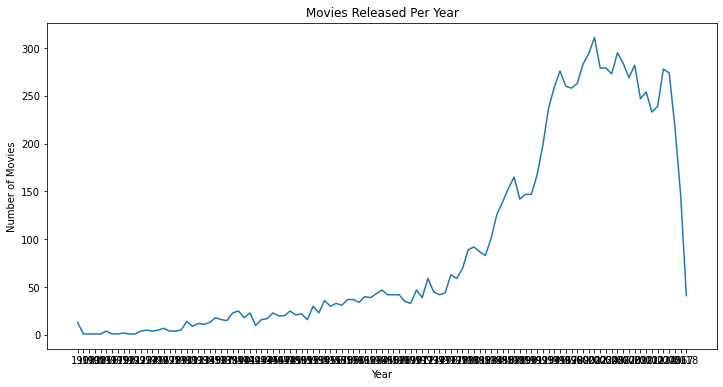

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas for plotting
pandas_df = movies_per_year.toPandas()

plt.figure(figsize=(12,6))
plt.plot(pandas_df['year'], pandas_df['count'])
plt.title('Movies Released Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()


In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Prepare training data
als_data = ratings_df.select("userId", "movieId", "rating").na.drop()

# Train/test split
(training, test) = als_data.randomSplit([0.8, 0.2], seed=42)


In [0]:
als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop",  # avoid NaN predictions
    rank=10,
    maxIter=10,
    regParam=0.1
)


In [0]:
model = als.fit(training)


In [0]:
predictions = model.transform(test)

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse:.4f}")


Root-mean-square error = 0.8764


In [0]:
# Generate top 10 movie recommendations for each user
user_recs = model.recommendForAllUsers(10)
display(user_recs.limit(5))


userId,recommendations
1,"List(List(33649, 5.609492), List(171495, 5.5740457), List(96004, 5.5391355), List(3379, 5.5391355), List(5915, 5.531417), List(3606, 5.515689), List(3358, 5.4966693), List(951, 5.4904156), List(78836, 5.4786415), List(170705, 5.4513636))"
2,"List(List(92643, 5.2148867), List(84847, 5.032443), List(49347, 5.02395), List(5075, 4.9752474), List(110130, 4.9229918), List(158882, 4.8931637), List(158398, 4.8931637), List(157775, 4.8931637), List(156025, 4.8931637), List(149508, 4.8931637))"
3,"List(List(89118, 7.090389), List(6835, 4.904598), List(5746, 4.904598), List(5181, 4.8346214), List(4518, 4.749784), List(2851, 4.612047), List(7899, 4.4141383), List(26409, 4.322455), List(158783, 4.0841312), List(86377, 4.005135))"
4,"List(List(96004, 4.876039), List(3379, 4.876039), List(3851, 4.86883), List(1733, 4.8322625), List(171, 4.827588), List(8477, 4.788594), List(1287, 4.7686963), List(1283, 4.7629046), List(1046, 4.7613835), List(7748, 4.751182))"
5,"List(List(187, 4.8225555), List(7096, 4.8136063), List(26171, 4.8011203), List(177593, 4.8004613), List(174053, 4.777703), List(3925, 4.768789), List(8235, 4.714485), List(6201, 4.714485), List(96004, 4.7095885), List(3379, 4.7095885))"


In [0]:
from pyspark.sql.functions import explode

recommendations = user_recs.withColumn("rec", explode("recommendations")) \
    .select("userId", col("rec.movieId").alias("movieId"), col("rec.rating").alias("predicted_rating"))

# Join with movie titles
recommended_movies = recommendations.join(movies_df, "movieId") \
    .select("userId", "clean_title", "predicted_rating")

display(recommended_movies.filter("userId =7"))


userId,clean_title,predicted_rating
7,Titanic,5.2149496
7,Frozen River,4.9753695
7,"Visitor, The",4.9753695
7,Tender Mercies,4.952336
7,Deathgasm,4.7349806
7,"Grand Day Out with Wallace and Gromit, A",4.7287335
7,The Artist,4.7210956
7,"Jetée, La",4.6727834
7,"African Queen, The",4.630086
7,Afterglow,4.59909


In [0]:
# Save recommendations as Parquet (preferred for big data)
recommended_movies.write.mode("overwrite").parquet("/FileStore/movielens/recommended_movies.parquet")

# Or save as CSV for easy download
recommended_movies.write.mode("overwrite").csv("/FileStore/movielens/recommended_movies_csv")
